# Implementing BERT on CommonLit Readability kaggle Dataset using Tensorflow and transformers
   In this competition the goal is to predict the ease of reading excerpts
  https://www.kaggle.com/c/commonlitreadabilityprize/overview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installing additional Libraries
If you are working on Google Colab:
* We need to install transformers library by huggingface 
* tensorflow-gpu to work using gpu

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.3MB/s 
     |████████████████████████████████| 3.3MB 47.7MB/s 
     |████████████████████████████████| 901kB 37.6MB/s 


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 38kB/s 


#### Check the GPU 

In [ ]:
!nvidia-smi

Mon May 31 10:28:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  #### Importing Libraries
  * pandas to read csv files and other data preprocessing
  * Numpy for arrays and Linear algebra
  * we use Tensorflow to build and train the model using bert
  * trnasformers library by huggingface for pretrained bert model (  'pip install transformers' - to install transformers library )

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

from transformers import TFBertModel, BertConfig, BertTokenizerFast

Hugging face [Docs](https://huggingface.co/transformers/quicktour.html)

In [ ]:
train_path = '/content/drive/MyDrive/commonLit/train.csv'
test_path = '/content/drive/MyDrive/commonLit/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [ ]:
ex_len = []
for i in train_df['excerpt']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  205 words


BERT has a max sequence length of 512 tokens.

If the text sequence length is more than the limit then we have 4 options (consider based on their importance):
* truncating at the end 
* take the end part
* take the middle part
* join the first and last part by removing the middle

according to this [research](https://arxiv.org/abs/1905.05583), cutting middle part shows best accuracy

### Tokenisation


In [ ]:
train_df['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

#### BERT model
* BERT Large – 24-layer, 1024-hidden, 16-heads, 336M parameters
* BERT base – 12-layer, 768-hidden, 12-heads, 110M parameters
* cased – Trained on cased English text
* uncased – Trained on lower-cased English text



[link for more info](https://huggingface.co/transformers/pretrained_models.html)

In [ ]:
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

[Docs](https://huggingface.co/transformers/glossary.html#input-ids) to learn about inputs to BERT model

In [ ]:
def encoder(df, tokenizer, label = 'excerpt', maxLen = 210):
    input_id = []
    token_type = []
    attention_mask = []
    for i in df[label].values:
        token = tokenizer(i, max_length = maxLen, truncation = True, padding = 'max_length', add_special_tokens = True)
        input_id.append(token['input_ids'])
        token_type.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    return np.array(input_id), np.array(token_type), np.array(attention_mask)

#### No need of pre - processing the text
  
* stemming: Bert uses BPE (Byte- Pair Encoding to shrink its vocab size), so words like run and running will ultimately be decoded to run + ##ing. So it's better not to convert running into run because, in some NLP problems, you need that information.
* De-Capitalization - Bert provides two models (lowercase and uppercase). One converts your sentence into lowercase, and others will not change related to the capitalization of your sentence. So you don't have to do any changes here just select the model for your use case.


In [ ]:
train_d = encoder(train_df, tokenizer)
test_d = encoder(test_df, tokenizer)

In [ ]:
train_d

(array([[  101,  2043,  1996, ...,  1010,  2021,   102],
        [  101,  2035,  2083, ...,  1010,  2017,   102],
        [  101,  2004,  5074, ...,  1010,  2205,   102],
        ...,
        [  101,  1996,  2117, ...,  4338,  2180,   102],
        [  101, 26778,  2024, ...,     0,     0,     0],
        [  101,  4176,  2024, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [ ]:
tok = train_d[0].flatten()[30:50]

print(train_d[0].shape, '\n')
print('original sequence:')
print(train_df['excerpt'][0].split()[30:50], '\n')
print('tokenised sequence:')
print(tokenizer.convert_ids_to_tokens(tok), '\n')
print(tokenizer.convert_ids_to_tokens(train_d[0].flatten()[0:10]))

(2834, 210) 

original sequence:
['canvas,', 'not', 'laid', 'on', 'smoothly,', 'but', 'rumpled', 'over', 'bumps', 'and', 'hillocks,', 'like', 'a', 'real', 'snow', 'field.', 'The', 'numerous', 'palms', 'and'] 

tokenised sequence:
['floor', 'was', 'covered', 'with', 'snow', '-', 'white', 'canvas', ',', 'not', 'laid', 'on', 'smoothly', ',', 'but', 'rum', '##pled', 'over', 'bumps', 'and'] 

['[CLS]', 'when', 'the', 'young', 'people', 'returned', 'to', 'the', 'ballroom', ',']


In [ ]:
# config will be downloaded and cached
model_config = BertConfig.from_pretrained(bert_model)

In [ ]:
model_config.output_hidden_states = True

In [ ]:
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# Downloads the model 
bert = TFBertModel.from_pretrained(bert_model, config = model_config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# tunable parameters
max_len = 210
learning_rate = 1e-4
epochs = 3

# callbacks
ckpt_dir = '/content/drive/MyDrive/commonLit/checkpoint/ckpt{epoch:02d}.h5'
ckpt = ModelCheckpoint(
    filepath = ckpt_dir,
    save_freq = 'epoch',
    save_weights_only=True)

optimizer = Adam(learning_rate = learning_rate)
loss = 'mse'
metrics = [RootMeanSquaredError()]
callbacks = [ckpt]

#### Defining the model 
 * Takes 3 inputs i.e., input_ids, token_type_ids, attention_mask and are given to the bert layer
 * bert layer outputs a tuple of output of all the layers. we only consider the first sequence(output of [CLS] token), which is passed to hidden layers with linear activation
 * we use linear activation as the labels are integers 

In [ ]:
input_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
token_type_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_type_ids')
attention_mask_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
inputs = [input_ids_i, token_type_ids_i, attention_mask_i]

bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]
output = bert_output[:, 0, :]

output = Dropout(0.1)(output)

output = Dense(10, activation = 'linear')(output)
output = Dense(1, activation = 'linear')(output)

model = Model(inputs = inputs, outputs = output)

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
print(bert_output.shape)

(None, 210, 768)


The output is usually [batch, maxlen, hidden_state], it can be narrowed down to [batch, 1, hidden_state] for [CLS] token, as the [CLS] token is 1st token in the sequence. Here , [batch, 1, hidden_state] can be equivalently considered as [batch, hidden_state].

Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification. Hence, for tasks such as classification using sentence representations, you can use [batch, hidden_state]. However, you can also consider [batch, maxlen, hidden_state], average across maxlen dimension to get averaged embeddings. However, some sequential tasks, such as classification using CNN or RNN requires, sequence of representations, during which you have to rely on [batch, maxlen, hidden_state]. Also, some training objectives such as predicting the masked words, or for SQUAD 1.1 (as shown in BERT paper), the entire sequence of embeddings [batch, maxlen, hidden_state] are used.

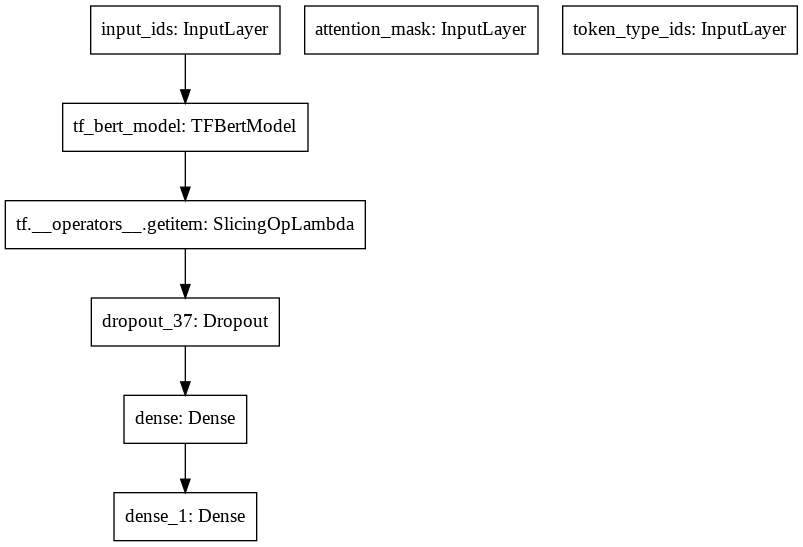

In [ ]:
plot_model(model)

In [ ]:
train_l = train_df['target'].values

val_prob = 0.1
split = int(len(train_l)*(1 - val_prob))
print(split)
print(2834 - split)
train_x = tuple(np.array(train_d)[:, :split, :])
train_y = train_l[:split]

val_x = tuple(np.array(train_d)[:, split:, :])
val_y = np.array(train_l[split:])
print(val_x[0].shape)
val_y.shape

2550
284
(284, 210)


(284,)

In [ ]:
model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs = epochs, callbacks = callbacks)
model.save_weights('/content/drive/MyDrive/commonLit/BERTv1.h5')

Epoch 1/3
80/80 [==============================] - 3555s 44s/step - loss: 0.3173 - root_mean_squared_error: 0.5633 - val_loss: 0.4816 - val_root_mean_squared_error: 0.6940
Epoch 2/3
80/80 [==============================] - 3507s 44s/step - loss: 0.1670 - root_mean_squared_error: 0.4086 - val_loss: 0.5703 - val_root_mean_squared_error: 0.7552
Epoch 3/3
80/80 [==============================] - 3408s 43s/step - loss: 0.1064 - root_mean_squared_error: 0.3262 - val_loss: 0.4519 - val_root_mean_squared_error: 0.6723


#### Predict the target for test data using trained model

In [ ]:
model.predict(test_d)